# Necessary Imports

In [1]:
import numpy as np
import os
import glob
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

import argparse
import ecdl

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# The arguments that we pass in

In [3]:
class myargs():
    def __init__(self):
        self.exp_id = 'efficientnet_round1'
        self.epochs = 200
        self.model = 'efficientnet'
        self.model_type = 'b3'
        self.image_dims = 300
        self.rotation_range = 10
        self.width_shift_range = 0.05
        self.height_shift_range = 0.05
        self.brightness_range = [0.8, 1.2]
        self.zoom_range = 0.05
        self.horizontal_flip = True
        self.vertical_flip = False
        self.validation_split = 0.1
        self.batch_size = 4
        self.class_mode = 'categorical'
        
# {
#     "exp_id": "repeat_experiment_batch_10",
#     "learning_rate": 0.0001,
#     "epochs": 200,
#     "rotation_range": 60,
#     "width_shift_range": 0.05,
#     "height_shift_range": 0.05,
#     "brightness_range": null,
#     "zoom_range": 0.05,
#     "horizontal_flip": true,
#     "vertical_flip": true,
#     "validation_split": 0.1,
#     "model": "categorical_efficientnet",
#     "image_dims": 224,
#     "class_mode": "categorical",
#     "batch_size": 10
# }        

args = myargs()


base_path = '/workspaces/ecdl'
exp_path = os.path.join(base_path, 'experiments')
model_path = os.path.join(exp_path, args.exp_id)

# Data Generators

In [4]:
train_dir = os.path.join(base_path, 'elbow_data/SABINE_Training_Set')

base_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=args.rotation_range,
                                                                       width_shift_range=args.width_shift_range,
                                                                       height_shift_range=args.height_shift_range,
                                                                       brightness_range=args.brightness_range,
                                                                       zoom_range=args.zoom_range,
                                                                       horizontal_flip=args.horizontal_flip,
                                                                       vertical_flip=args.vertical_flip,
                                                                       rescale=1./255,
                                                                       validation_split = args.validation_split)

bas2_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                       validation_split = args.validation_split)



train_data_gen = base_image_generator.flow_from_directory(batch_size=args.batch_size,
                                                        target_size=(args.image_dims, args.image_dims),
                                                        directory=train_dir,
                                                        shuffle=True,
                                                        class_mode=args.class_mode,
                                                        subset='training')



val_data_gen = bas2_image_generator.flow_from_directory(batch_size=args.batch_size,
                                                        target_size=(args.image_dims, args.image_dims),
                                                        directory=train_dir,
                                                        shuffle=True,
                                                        class_mode=args.class_mode,
                                                        subset='validation')

Found 993 images belonging to 2 classes.
Found 109 images belonging to 2 classes.


In [5]:
train_sample = next(train_data_gen)
val_sample = next(val_data_gen)

Text(0.5, 0, 'Validation')

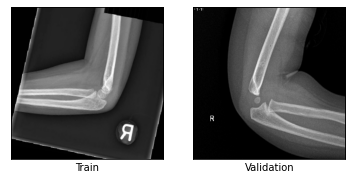

In [6]:
plt.subplot(1,2,1)
plt.imshow(train_sample[0][0,...])
plt.xticks([])
plt.yticks([])
plt.xlabel('Train')
plt.subplot(1,2,2)
plt.imshow(val_sample[0][0,...])
plt.xticks([])
plt.yticks([])
plt.xlabel('Validation')

In [7]:
input_shape=train_sample[0].shape[1:]
print(input_shape)

(300, 300, 3)


# Model

In [8]:
from efficientnet.tfkeras import EfficientNetB3

basic_efficient_net = EfficientNetB3(
        weights='imagenet',
        input_shape=input_shape,
        include_top=True,
#         pooling='max'
    )
basic_efficient_net.summary()

Model: "efficientnet-b3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [8]:
from efficientnet.tfkeras import EfficientNetB3

efficient_net = EfficientNetB3(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False,
#         pooling='max'
    )

# Basic
# x = tf.keras.layers.Dense(128, activation="relu", name="dense_1")(efficient_net.output)
# x = tf.keras.layers.Dense(128, activation="relu", name="dense_2")(x)
# outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred")(x)

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(efficient_net.output)
# x = tf.keras.layers.BatchNormalization()(x)
top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred")(x)

model = tf.keras.Model(efficient_net.input, outputs, name="EfficientNet")

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [10]:
from efficientnet.tfkeras import EfficientNetB0

basic_efficient_net = EfficientNetB0(
        weights='imagenet',
#         input_shape=input_shape,
        include_top=True,
#         pooling='max'
    )
basic_efficient_net.summary()

21831680/21826536 [==============================] - 1s 0us/step
Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
___________________

block5a_project_conv (Conv2D)   (None, 14, 14, 112)  53760       block5a_se_excite[0][0]          
__________________________________________________________________________________________________
block5a_project_bn (BatchNormal (None, 14, 14, 112)  448         block5a_project_conv[0][0]       
__________________________________________________________________________________________________
block5b_expand_conv (Conv2D)    (None, 14, 14, 672)  75264       block5a_project_bn[0][0]         
__________________________________________________________________________________________________
block5b_expand_bn (BatchNormali (None, 14, 14, 672)  2688        block5b_expand_conv[0][0]        
__________________________________________________________________________________________________
block5b_expand_activation (Acti (None, 14, 14, 672)  0           block5b_expand_bn[0][0]          
__________________________________________________________________________________________________
block5b_dw

Total params: 5,330,564
Trainable params: 5,288,548
Non-trainable params: 42,016
__________________________________________________________________________________________________


In [11]:
from efficientnet.tfkeras import EfficientNetB0

efficient_net = EfficientNetB0(
        weights='imagenet',
        input_shape=input_shape,
        include_top=False,
#         pooling='max'
    )

# Basic
# x = tf.keras.layers.Dense(128, activation="relu", name="dense_1")(efficient_net.output)
# x = tf.keras.layers.Dense(128, activation="relu", name="dense_2")(x)
# outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred")(x)

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(efficient_net.output)
# x = tf.keras.layers.BatchNormalization()(x)
top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(2, activation="softmax", name="pred")(x)

model = tf.keras.Model(efficient_net.input, outputs, name="EfficientNet")

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 32) 0           stem_bn[0][0]                    
______________________

block5a_expand_activation (Acti (None, 19, 19, 480)  0           block5a_expand_bn[0][0]          
__________________________________________________________________________________________________
block5a_dwconv (DepthwiseConv2D (None, 19, 19, 480)  12000       block5a_expand_activation[0][0]  
__________________________________________________________________________________________________
block5a_bn (BatchNormalization) (None, 19, 19, 480)  1920        block5a_dwconv[0][0]             
__________________________________________________________________________________________________
block5a_activation (Activation) (None, 19, 19, 480)  0           block5a_bn[0][0]                 
__________________________________________________________________________________________________
block5a_se_squeeze (GlobalAvera (None, 480)          0           block5a_activation[0][0]         
__________________________________________________________________________________________________
block5a_se

# Callbacks

In [9]:
exp_path = os.path.join('/workspaces/ecdl/experiments', args.exp_id)
checkpoint = tf.keras.callbacks.ModelCheckpoint(exp_path+'/weights.{epoch}-{val_accuracy:.4f}.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', verbose = 1, patience=50)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(exp_path,'result.csv'))
delete_excess = ecdl.callbacks.delete_excess_callback(exp_folder=exp_path)

# callbacks_list = [checkpoint, earlystopping, csv_logger, delete_excess]

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.8,
                                                 patience=5)


callbacks_list = [checkpoint, earlystopping, csv_logger, delete_excess, reduce_lr]

# Training

In [10]:
history = model.fit(
        train_data_gen,
        epochs = args.epochs,
        steps_per_epoch = len(train_data_gen),        
        validation_data = val_data_gen,
        verbose = 1,
        validation_steps = len(val_data_gen),
        callbacks=callbacks_list)

Epoch 1/200
249/249 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.5196
Epoch 00001: val_accuracy improved from -inf to 0.51376, saving model to /workspaces/ecdl/experiments/efficientnet_round1/weights.1-0.5138.hdf5
249/249 [==============================] - 36s 143ms/step - loss: 0.7886 - accuracy: 0.5196 - val_loss: 0.9956 - val_accuracy: 0.5138
Epoch 2/200
249/249 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.5599
Epoch 00002: val_accuracy improved from 0.51376 to 0.60550, saving model to /workspaces/ecdl/experiments/efficientnet_round1/weights.2-0.6055.hdf5
249/249 [==============================] - 34s 136ms/step - loss: 0.6943 - accuracy: 0.5599 - val_loss: 2.8950 - val_accuracy: 0.6055
Epoch 3/200
249/249 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.6052
Epoch 00003: val_accuracy improved from 0.60550 to 0.66972, saving model to /workspaces/ecdl/experiments/efficientnet_round1/weights.3-0.6697.hdf5
249

249/249 [==============================] - ETA: 0s - loss: 0.0490 - accuracy: 0.9839
Epoch 00055: val_accuracy did not improve from 0.85321
249/249 [==============================] - 33s 131ms/step - loss: 0.0490 - accuracy: 0.9839 - val_loss: 0.8025 - val_accuracy: 0.7890
Epoch 56/200
249/249 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9789
Epoch 00056: val_accuracy did not improve from 0.85321
249/249 [==============================] - 33s 132ms/step - loss: 0.0522 - accuracy: 0.9789 - val_loss: 0.8927 - val_accuracy: 0.7890
Epoch 57/200
249/249 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9789
Epoch 00057: val_accuracy did not improve from 0.85321
249/249 [==============================] - 33s 131ms/step - loss: 0.0663 - accuracy: 0.9789 - val_loss: 0.8003 - val_accuracy: 0.7798
Epoch 58/200
249/249 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9748
Epoch 00058: val_accuracy did not improve from 0.85321

Epoch 84/200
249/249 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9940
Epoch 00084: val_accuracy did not improve from 0.85321
249/249 [==============================] - 33s 131ms/step - loss: 0.0192 - accuracy: 0.9940 - val_loss: 0.8631 - val_accuracy: 0.8073
Epoch 85/200
249/249 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9950
Epoch 00085: val_accuracy did not improve from 0.85321
249/249 [==============================] - 33s 132ms/step - loss: 0.0142 - accuracy: 0.9950 - val_loss: 0.8293 - val_accuracy: 0.8165
Epoch 86/200
249/249 [==============================] - ETA: 0s - loss: 0.0226 - accuracy: 0.9930
Epoch 00086: val_accuracy did not improve from 0.85321
249/249 [==============================] - 33s 132ms/step - loss: 0.0226 - accuracy: 0.9930 - val_loss: 0.8283 - val_accuracy: 0.8073
Epoch 87/200
249/249 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9960
Epoch 00087: val_accuracy did not improve

In [11]:
model.evaluate(val_data_gen)

28/28 [==============================] - 1s 30ms/step - loss: 0.9469 - accuracy: 0.8349


[0.9469047784805298, 0.8348624110221863]

(4, 300, 300, 3)
(4, 2)


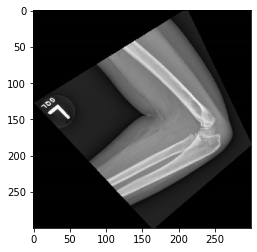

In [12]:
# import matplotlib.pyplot as plt
sample = next(val_data_gen)
print(sample[0].shape)
print(sample[1].shape)
plt.imshow(sample[0][0,...])

# Saving the model

In [13]:
model.save(model_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /workspaces/ecdl/experiments/efficientnet_round1/assets


# Implementing the learning rate scheduler

In [14]:
SGDw_optimizer = tfa.optimizers.SGDW(
    weight_decay= 0.005,
    learning_rate= 0.01,
    momentum= 0.9,
    nesterov= False,
    name= 'SGDW',    
)


model.compile(optimizer=SGDw_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch % 15==0:
    return lr * 0.1
  else:
    return lr



reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)


# reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
#                               patience=5, min_lr=0.000001)


callbacks_list = [checkpoint, earlystopping, csv_logger, delete_excess, reduce_lr]
history = model.fit(
        train_data_gen,
        epochs = args.epochs,
        steps_per_epoch = len(train_data_gen),        
        validation_data = val_data_gen,
        verbose = 1,
        validation_steps = len(val_data_gen),
        callbacks=callbacks_list)

Epoch 1/200
249/249 [==============================] - ETA: 0s - loss: 0.2516 - accuracy: 0.8943
Epoch 00001: val_accuracy did not improve from 0.85321
249/249 [==============================] - 35s 140ms/step - loss: 0.2516 - accuracy: 0.8943 - val_loss: 0.7003 - val_accuracy: 0.5505
Epoch 2/200
249/249 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.5962
Epoch 00002: val_accuracy did not improve from 0.85321
249/249 [==============================] - 34s 137ms/step - loss: 0.6551 - accuracy: 0.5962 - val_loss: 0.6897 - val_accuracy: 0.5505
Epoch 3/200
249/249 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5468
Epoch 00003: val_accuracy did not improve from 0.85321
249/249 [==============================] - 34s 136ms/step - loss: 0.6903 - accuracy: 0.5468 - val_loss: 0.6900 - val_accuracy: 0.5505
Epoch 4/200
249/249 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.5468
Epoch 00004: val_accuracy did not improve fro

KeyboardInterrupt: 